# E[18] OCRs

# Google OCR

In [5]:
def detect_text(path):
    """Detects text in the file."""
    from google.cloud import vision
    import io
    client = vision.ImageAnnotatorClient()

    with io.open(path, 'rb') as image_file:
        content = image_file.read()
        
    image = vision.Image(content=content)

    response = client.text_detection(image=image)
    texts = response.text_annotations
    print('Texts:')

    for text in texts:
       print('\n"{}"'.format(text.description))

    vertices = (['({},{})'.format(vertex.x, vertex.y)
                 for vertex in text.bounding_poly.vertices])

    print('bounds: {}'.format(','.join(vertices)))

    if response.error.message:
        raise Exception(
            '{}\nFor more info on error messages, check: '
            'https://cloud.google.com/apis/design/errors'.format(
                response.error.message))


In [6]:
# 다운받은 인증키 경로가 정확하게 지정되어 있어야 합니다. 
!ls -l $GOOGLE_APPLICATION_CREDENTIALS

import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] =  os.getenv('HOME')+'/aiffel/ocr_python/my_google_api_key.json'

# 입력 이미지 경로를 지정해 주세요.
# (예시) path = os.getenv('HOME')+'/aiffel/ocr_python/test_image.png'
#path = os.getenv('HOME')+'aiffel/aiffel/ocr_python/test_image.jpeg
path = '/home/aiffel/aiffel/ocr_python/test_image.jpeg'
# 위에서 정의한 OCR API 이용 함수를 호출해 봅시다.
detect_text(path)

-rw-rw-r-- 1 aiffel aiffel 2344  3월 21 23:15 /home/aiffel/aiffel/ocr_python/my_google_api_key.json
Texts:

"ENGLIS H
"

"ENGLIS"

"H"
bounds: (268,59),(290,59),(289,95),(267,95)


# Keras_ocr

In [25]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /home/aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /home/aiffel/.keras-ocr/crnn_kurapan.h5


In [26]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  #'https://source.unsplash.com/M7mu6jXlcns/640x460',
  #'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  #'https://source.unsplash.com/98uYQ-KupiE',
  #'https://source.unsplash.com/j9JoYpaJH3A',
  #'https://source.unsplash.com/eBkEJ9cH5b4'
  '/home/aiffel/aiffel/ocr_python/test_image.jpeg',
  '/home/aiffel/aiffel/ocr_python/test_image_2.jpeg'
]


images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]
#path = '/home/aiffel/aiffel/ocr_python/test_image.jpeg'
#images = [ keras_ocr.tools.read(path)]
#prediction_groups = [pipeline.recognize([path])]

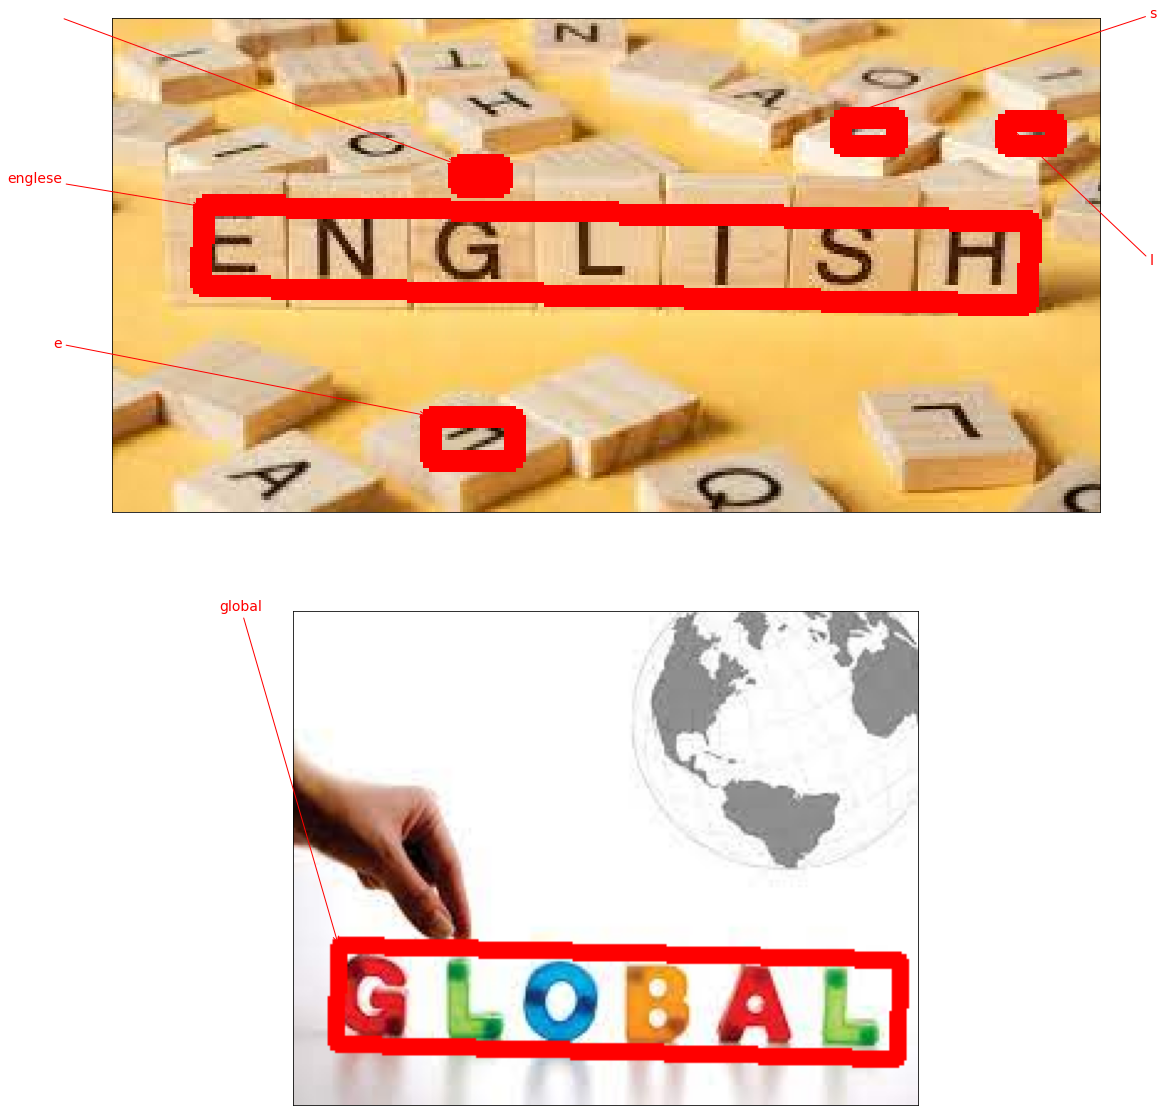

In [27]:
# Plot the predictions

fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

# Tesseract OCR

In [32]:
import os
import pytesseract
from PIL import Image
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image_3.jpg'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 

cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

/home/aiffel/aiffel/ocr_python/0000.png
/home/aiffel/aiffel/ocr_python/0001.png
/home/aiffel/aiffel/ocr_python/0002.png
/home/aiffel/aiffel/ocr_python/0003.png
/home/aiffel/aiffel/ocr_python/0004.png
/home/aiffel/aiffel/ocr_python/0005.png
/home/aiffel/aiffel/ocr_python/0006.png
/home/aiffel/aiffel/ocr_python/0007.png
/home/aiffel/aiffel/ocr_python/0008.png
/home/aiffel/aiffel/ocr_python/0009.png
/home/aiffel/aiffel/ocr_python/0010.png


In [33]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

WAY

DD

Fil

Co!


ONE

YOU'RE.

Tues

THE MAN

aaa =


Done


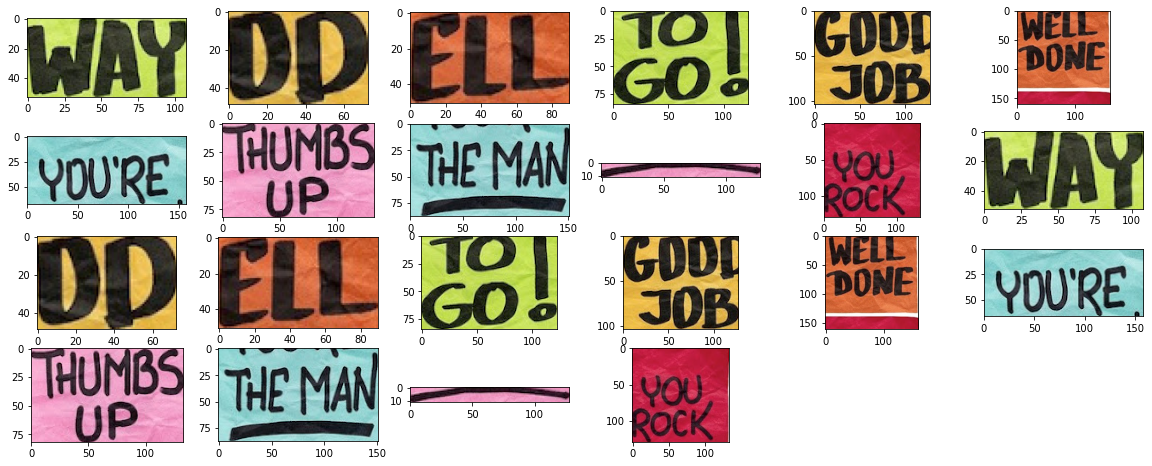

In [48]:
from glob import glob
from os.path import isdir
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

for img in cropped_image_path_list:
    n = cv2.imread(img)
    img_crop_list.append(n)
plt.figure(figsize=(20,10))
for i in range(len(img_crop_list)):
    plt.subplot(5,6,i+1)
    img = cv2.cvtColor(img_crop_list[i], cv2.COLOR_BGR2RGB)
    plt.imshow(img)

# 루브릭
1. OCR을 활용하여 구현하려는 서비스의 기획이 타당한가?
 - 목표로 하는 서비스가 OCR를 적용 가능하며, OCR을 활용했을 때 더욱 유용해진다.
2. 모델 평가기준이 명확하고 체계적으로 세워졌는가?
 - 평가 기준에 부합하는 테스트 데이터의 특징이 무엇인지 명확하게 제시되었다.
3. 평가기준에 따라 충분한 분량의 테스트가 진행되고 그 결과가 잘 정리되었는가?
 - 최대 20장까지의 테스트 이미지를 사용해 제시된 평가 기준에 따른 테스트 결과가 잘 정리되어 결론이 도출되었다.


# 결과 
 - 3장의 이미지를 통해 각 모델의 문자 인식을 확인할 수 있었다.
 - cpu, gpu 사용량 대비 성능을 따진다면 모델의 효율